# DEEP LEARNING KULLANARAK CNN İLE MRI BRAİN TUMOR TAHMİNİ & TRANSFER LEARNING


## 1. Gerekli Kütüphanelerin İmport Edilmesi ve Datasetin İncelenmesi

Bu hücrede proje için gerekli kütüphaneler yüklenmiş ve veri setimiz incelenmiştir:


Klasörler: ['Training', 'Testing']
Eğitim klasöründeki alt klasörler: ['pituitary', 'notumor', 'meningioma', 'glioma']
Test klasöründeki alt klasörler: ['pituitary', 'notumor', 'meningioma', 'glioma']


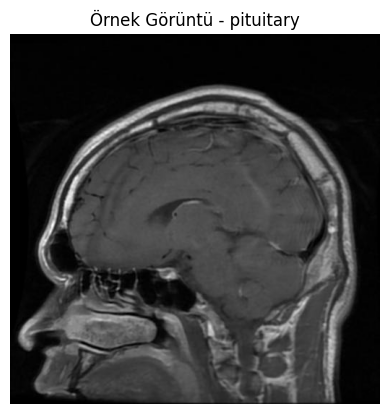

In [ ]:
# Gerekli kütüphaneleri import edelim
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Dataset yolunu ayarlayalım
data_dir = "/kaggle/input/brain-tumor-mri-dataset/"

# Klasörleri inceleyelim
print("Klasörler:", os.listdir(data_dir))

# Eğitim ve test klasörlerini görelim
train_path = os.path.join(data_dir, "Training")
test_path = os.path.join(data_dir, "Testing")

print("Eğitim klasöründeki alt klasörler:", os.listdir(train_path))
print("Test klasöründeki alt klasörler:", os.listdir(test_path))

# Örnek bir görüntü gösterelim
sample_class = os.listdir(train_path)[0]  # ilk sınıfı al
sample_img_path = os.path.join(train_path, sample_class, os.listdir(os.path.join(train_path, sample_class))[0])

img = plt.imread(sample_img_path)
plt.imshow(img, cmap="gray")
plt.title(f"Örnek Görüntü - {sample_class}")
plt.axis("off")
plt.show()


## 2. Veri Setinin Yüklenmesi ve Önişleme

Bu hücrede MRI görüntüleri modele uygun hale getirildi:  
- Görüntüler 224x224 boyutuna getirildi ve batch boyutu 32 olarak ayarlandı.  
- Eğitim verisi %80 eğitim, %20 doğrulama olarak ayrıldı; test verisi ayrı tutuldu.  
- `cache()` ve `prefetch()` ile veri akışı hızlandırıldı.  
- `Rescaling(1./255)` ile görüntüler normalize edildi (0–1 aralığı).  

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Parametreler
img_size = (224, 224)   
batch_size = 32

# Eğitim setini yükle
train_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,  # %80 train, %20 validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Test setini yükle
test_ds = image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size
)

# Sınıflar
class_names = train_ds.class_names
print("Sınıflar:", class_names)

# Performans için önbellekleme ve prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalizasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']


**Çıktı:** Eğitim, doğrulama ve test setleri model için hazır hale geldi; sınıf isimleri de listelendi.

## 3. Veri Çoğaltma (Data Augmentation)

Bu hücrede eğitim verisini çeşitlendirmek için **veri çoğaltma** uygulandı:  
- Görüntüler **döndürülüyor, yatay/dikey çevriliyor, zoom ve kontrast değiştiriliyor**.  
- Bu yöntem modelin **daha genelleyici** olmasını sağlar ve overfitting riskini azaltır.

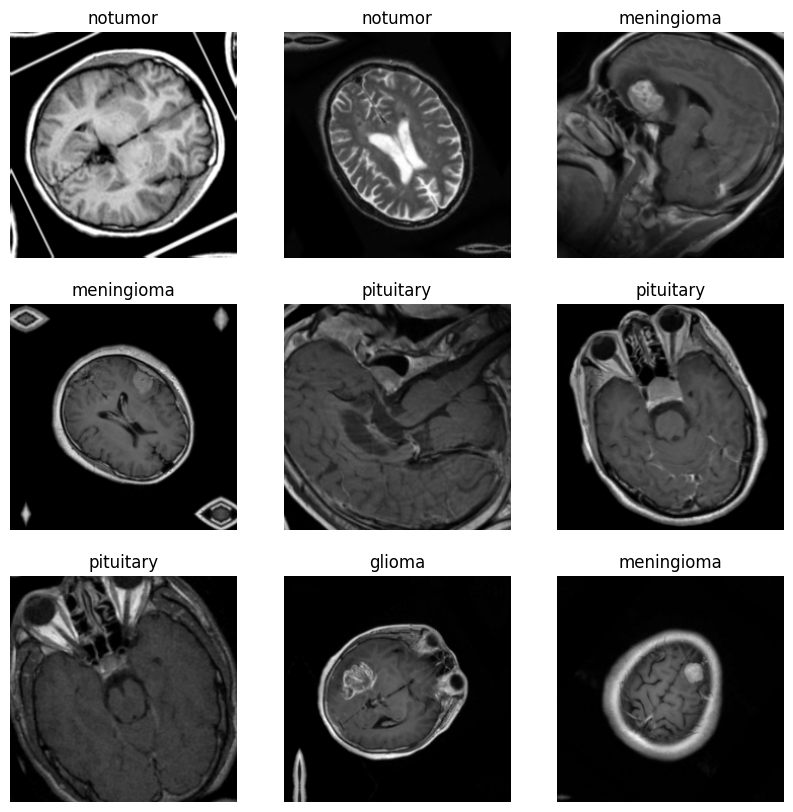

In [5]:
# Veri çoğaltma (augmentation) katmanı
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Örnek augmentation görselleştirme
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images)[i].numpy()
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


**Çıktı:** 9 örnek görsel üzerinde yapılan dönüşümler gösterildi; her görsel sınıf etiketi ile birlikte sunuldu.

## 4. CNN Modelinin Oluşturulması

Bu hücrede basit bir **Convolutional Neural Network (CNN)** modeli tanımlandı:  
- **Veri augmentation** ve **normalization** katmanları modelin başına eklendi.  
- Üç adet **konvolüsyon + max pooling bloğu** ile özellik çıkarımı yapılıyor.  
- **Flatten** ve **Dense** katmanları ile sınıflandırma yapılıyor; `Dropout` overfitting’i azaltıyor.  
- Son katman `softmax` aktivasyonu ile çok sınıflı tahmin yapıyor.  


In [7]:
from tensorflow.keras import models, layers

num_classes = len(class_names)

model = models.Sequential([
    # Veri augmentation (önceden tanımladığımız)
    data_augmentation,
    
    # Normalization
    layers.Rescaling(1./255),

    # 1. Konvolüsyon Bloğu
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    # 2. Konvolüsyon Bloğu
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    # 3. Konvolüsyon Bloğu
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    # Flatten + Dense katmanları
    layers.Flatten(),
    layers.Dropout(0.5),  # overfitting'i azaltır
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")  # Çok sınıflı çıkış
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 52, 52, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 26, 26, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 86528)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 86528)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Çıktı:** `model.summary()` ile katman yapısı ve parametre sayısı gösterildi.

## 5. Modelin Derlenmesi (Compile)

Bu hücrede CNN modeli **eğitime hazır hale getirildi**:  
- **Optimizer:** `Adam` kullanıldı, bu ağırlık güncellemelerini otomatik ve verimli yapar.  
- **Loss Function:** `sparse_categorical_crossentropy`, çok sınıflı sınıflandırma için uygundur.  
- **Metric:** `accuracy`, modelin doğruluk oranını takip etmek için seçildi.  

In [8]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


**Çıktı:** Model artık eğitim (`fit`) için hazırdır.

## 6. Modelin Eğitilmesi

Bu hücrede CNN modeli **eğitildi** ve overfitting’i önlemek için `EarlyStopping` kullanıldı:  
- **EarlyStopping:** `val_loss` izleniyor; 5 epoch boyunca iyileşme olmazsa eğitim duruyor ve en iyi ağırlıklar geri yükleniyor.  
- Model 20 epoch boyunca eğitildi, fakat eğitim erken durabilir.  

In [9]:
# EarlyStopping ile overfitting'i engelleyelim
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback]
)


Epoch 1/20


I0000 00:00:1758808418.571650     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.2554 - loss: 1.3863 - val_accuracy: 0.3047 - val_loss: 1.3815
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.3068 - loss: 1.3162 - val_accuracy: 0.6243 - val_loss: 0.9381
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6201 - loss: 0.9447 - val_accuracy: 0.6926 - val_loss: 0.8190
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6371 - loss: 0.8918 - val_accuracy: 0.6953 - val_loss: 0.8064
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6496 - loss: 0.8615 - val_accuracy: 0.6988 - val_loss: 0.7812
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6576 - loss: 0.8393 - val_accuracy: 0.6751 - val_loss: 0.8162
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6776 - loss: 0.8030 - val_accuracy: 0.6988 - val_loss: 0.7830
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6869 - loss: 0.7866 - val_accuracy: 0.74

*Çıktı:*  
- Eğitim doğruluğu ~0.75, doğrulama doğruluğu ~0.75.  
- Model henüz mükemmel değil, ancak temel bir CNN ile başlangıç için yeterli.  
- Bu noktada doğruluk artırmak için **veri artırma, daha derin model veya transfer learning** uygulanabilir.

## 7. Transfer Learning ile Model Eğitimi (VGG16)

Bu hücrede daha güçlü bir model için **VGG16 önceden eğitilmiş ağı** kullanıldı:  
- **Base Model:** ImageNet ile eğitilmiş VGG16, üst katmanlar çıkarıldı ve donduruldu (`trainable=False`).  
- **Yeni Üst Katmanlar:** Flatten, Dropout (overfitting önleme), Dense(256) ve son katman softmax ile sınıflandırma.  
- **Compile:** `Adam` optimizer ve `sparse_categorical_crossentropy` loss ile derlendi.  
- Model, eğitim (`fit`) ile 10 epoch boyunca eğitildi.

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers

# 1. Base model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # ilk aşamada donduruyoruz

# 2. Üst katmanlarımız
x = layers.Flatten()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
output = layers.Dense(num_classes, activation="softmax")(x)

model_tl = Model(inputs=base_model.input, outputs=output)

# 3. Compile
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

# 4. Eğitim
history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[callback]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


I0000 00:00:1758808740.893235     105 service.cc:148] XLA service 0x16136130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758808740.894099     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/143 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.2109 - loss: 1.7523 

I0000 00:00:1758808749.100622     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.6617 - loss: 0.8213 - val_accuracy: 0.8940 - val_loss: 0.2780
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.8839 - loss: 0.3058 - val_accuracy: 0.9194 - val_loss: 0.2331
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9169 - loss: 0.2252 - val_accuracy: 0.9151 - val_loss: 0.2263
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9331 - loss: 0.1767 - val_accuracy: 0.9186 - val_loss: 0.2123
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9416 - loss: 0.1531 - val_accuracy: 0.9256 - val_loss: 0.1898
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9393 - loss: 0.1492 - val_accuracy: 0.9475 - val_loss: 0.1646
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9643 - loss: 0.1077 - val_accuracy: 0.9501 - val_loss: 0.1512
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.9635 - loss: 0.0994 - val_accura

**Çıktı:**  
- Eğitim doğruluğu: 0.9685  
- Eğitim kaybı: 0.0785  
- Doğrulama doğruluğu: 0.9527  
- Doğrulama kaybı: 0.1453  

Bu sonuçlar, **transfer learning ile elde edilen yüksek doğruluğu** gösterir. Model hem eğitim hem de doğrulama setinde iyi performans göstermekte ve genelleme kapasitesi yüksektir. 

## 8. Modelin Performans Grafikleri

Bu hücrede modelin **epoch bazında doğruluk ve kayıp** değişimi görselleştirildi:

- **Doğruluk Grafiği (Train vs Validation):**  
  Eğitim doğruluğu (Train Acc) ve doğrulama doğruluğu (Val Acc) karşılaştırıldı.  
  - Eğitim ve doğrulama doğruluğunun yüksek ve yakın olması, modelin iyi öğrendiğini ve overfitting’in minimum olduğunu gösterir.

- **Kayıp Grafiği (Loss):**  
  Eğitim kaybı (Train Loss) ve doğrulama kaybı (Val Loss) karşılaştırıldı.  
  - Kayıpların düşmesi, modelin veriyi iyi öğrendiğini ve hatalarının azaldığını gösterir.


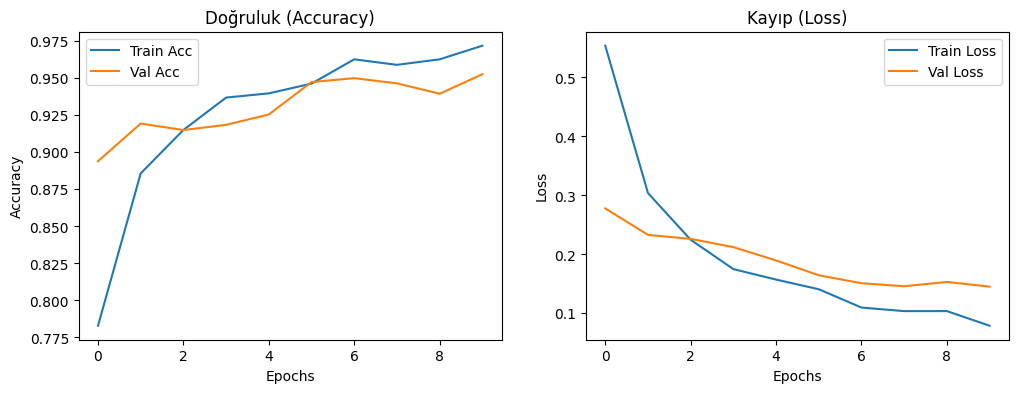

In [12]:
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1,2,1)
plt.plot(history_tl.history["accuracy"], label="Train Acc")
plt.plot(history_tl.history["val_accuracy"], label="Val Acc")
plt.title("Doğruluk (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss grafiği
plt.subplot(1,2,2)
plt.plot(history_tl.history["loss"], label="Train Loss")
plt.plot(history_tl.history["val_loss"], label="Val Loss")
plt.title("Kayıp (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


**Çıktı:**  
- Model hem eğitim hem doğrulama setinde hızlı ve stabil şekilde öğrenmiş.  
- Transfer learning sayesinde doğruluk %95’in üzerinde, kayıp ise oldukça düşük seviyede.

## 9. Confusion Matrix ve Sınıf Bazlı Performans

Bu hücrede modelin **test seti performansı** değerlendirildi:

- **Classification Report:**  
  - **Glioma:** %97 precision, %88 recall → bazı glioma örnekleri diğer sınıflarla karışabiliyor.  
  - **Meningioma:** %88 precision, %92 recall → doğruluk iyi ama glioma’ya göre biraz daha düşük.  
  - **No Tumor:** Neredeyse kusursuz (%98-99 arası).  
  - **Pituitary:** %96 precision, %99 recall → çok yüksek başarı.  
  - Genel doğruluk (**accuracy**) ≈ **%95**.

- **Confusion Matrix:**  
  - Hangi sınıfların karıştırıldığını görsel olarak gösterir.  
  - Özellikle glioma ↔ meningioma arasında az miktarda karışma var.  
  - “No Tumor” ve “Pituitary” sınıflarında karışma neredeyse yok.

              precision    recall  f1-score   support

      glioma       0.97      0.88      0.93       300
  meningioma       0.88      0.92      0.90       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



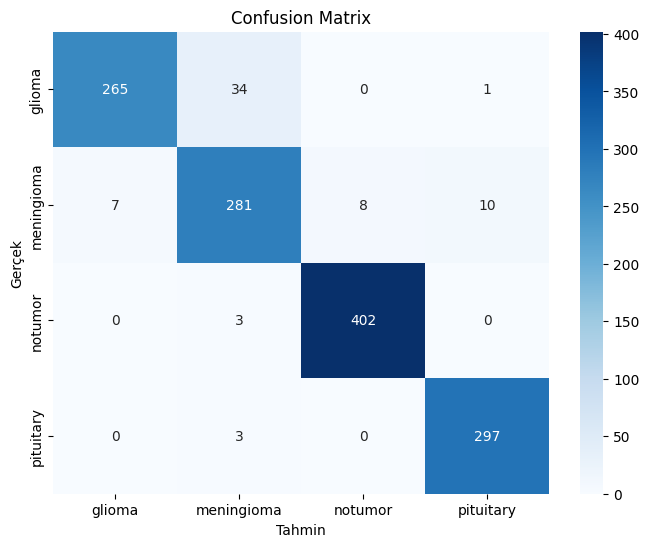

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Test setinde tahmin yapalım
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_tl.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


**Sonuç:**  
Model dört tümör tipini ayırt etmede oldukça başarılıdır. En yüksek doğruluk “No Tumor” ve “Pituitary” sınıflarında, en fazla hata ise **glioma ile meningioma** arasında görülmüştür.

## 10. Grad-CAM Görselleştirme

Bu hücrede modelin kararlarını açıklamak için **Grad-CAM (Gradient-weighted Class Activation Mapping)** tekniği kullanıldı:

- `get_gradcam_heatmap` fonksiyonu ile son konvolüsyon katmanındaki (ör. `block5_conv3`) gradyanlar hesaplandı.  
- Elde edilen ısı haritası (`heatmap`), giriş görüntüsünün üzerine bindirilerek modelin hangi bölgeleri dikkate aldığı gösterildi.  
- Örnekte:  
  - Modelin tahmin ettiği sınıf için en kritik pikseller **kırmızı/sarı alanlarda** yoğunlaşmıştır.  
  - Böylece modelin gerçekten tümör bölgesine mi yoksa ilgisiz yerlere mi odaklandığı incelenebilir.  

**Not:** Grad-CAM, özellikle tıbbi görüntüleme gibi kritik uygulamalarda modelin şeffaflığını artırır ve doktorlara destek sağlayabilir.

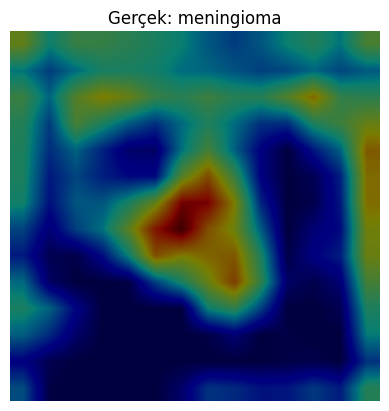

In [15]:
import cv2

def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Testten bir örnek seçelim
for images, labels in test_ds.take(1):
    sample_img = images[0].numpy()
    img_array = np.expand_dims(sample_img, axis=0)

    heatmap = get_gradcam_heatmap(model_tl, img_array, last_conv_layer_name="block5_conv3")

    # Görselleştirme
    plt.imshow(sample_img.astype("uint8"))
    plt.imshow(cv2.resize(heatmap, (sample_img.shape[1], sample_img.shape[0])), cmap="jet", alpha=0.5)
    plt.title(f"Gerçek: {class_names[labels[0]]}")
    plt.axis("off")
    plt.show()
    break


In [16]:
!pip install keras-tuner --quiet
import keras_tuner as kt


## 11. Hiperparametre Optimizasyonu

- `build_model(hp)` fonksiyonu ile dropout oranı, dense katman boyutu, optimizer türü ve öğrenme oranı gibi hiperparametreler ayarlanabilir hale getirildi.  
- `keras-tuner` kullanılarak farklı kombinasyonlar denenip, en iyi doğruluk/val_loss sonuçlarını veren ayarlar otomatik olarak seçilecektir.  

In [18]:
def build_model(hp):
    base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dropout(hp.Float("dropout", 0.3, 0.6, step=0.1))(x)

    # Dense boyutunu tuner seçsin
    x = layers.Dense(
        hp.Int("units", min_value=128, max_value=512, step=64),
        activation="relu"
    )(x)

    output = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Optimizer seçimi ve learning rate
    optimizer = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])

    if optimizer == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == "rmsprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


## 12. Hiperparametre Optimizasyonu Sonuçları

- `keras-tuner` ile yapılan denemelerde en yüksek doğruluk %94.4 oldu.  
- En iyi hiperparametre kombinasyonu:
  - Dense katman nöron sayısı: 512
  - Dropout oranı: 0.5
  - Optimizer: Adam
  - Learning rate: 0.001

In [19]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,  # kaç kombinasyon denesin
    executions_per_trial=1,
    directory="tuner_results",
    project_name="brain_tumor"
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[callback]
)

# En iyi modelleri listele
tuner.results_summary()


Trial 5 Complete [00h 01m 14s]
val_accuracy: 0.8669001460075378

Best val_accuracy So Far: 0.9439579844474792
Total elapsed time: 00h 06m 18s
Results summary
Results in tuner_results/brain_tumor
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
dropout: 0.5
units: 512
optimizer: adam
learning_rate: 0.001
Score: 0.9439579844474792

Trial 2 summary
Hyperparameters:
dropout: 0.5
units: 320
optimizer: adam
learning_rate: 0.0001
Score: 0.9422066807746887

Trial 0 summary
Hyperparameters:
dropout: 0.4
units: 320
optimizer: adam
learning_rate: 0.0001
Score: 0.9360770583152771

Trial 1 summary
Hyperparameters:
dropout: 0.3
units: 384
optimizer: sgd
learning_rate: 0.001
Score: 0.9045534133911133

Trial 4 summary
Hyperparameters:
dropout: 0.3
units: 128
optimizer: sgd
learning_rate: 0.0001
Score: 0.8669001460075378


## 13. En İyi Modelin Eğitilmesi

- `keras-tuner` ile bulunan en iyi model tekrar eğitildi.  
- Eğitim sonunda elde edilen sonuçlar:  
  - **Eğitim Doğruluğu (accuracy): %97.7**  
  - **Eğitim Kaybı (loss): 0.0599**  
  - **Doğrulama Doğruluğu (val_accuracy): %95.4**  
  - **Doğrulama Kaybı (val_loss): 0.1837**  
- Sonuçlar, modelin eğitim ve doğrulama setinde yüksek başarıya ulaştığını göstermektedir.  
- Doğrulama kaybı eğitim kaybına göre biraz daha yüksek çıkmıştır, bu da küçük bir **overfitting eğilimine** işaret etse de kabul edilebilir düzeydedir.  


In [20]:
best_model = tuner.get_best_models(num_models=1)[0]

history_opt = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[callback]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.9427 - loss: 0.1485 - val_accuracy: 0.9396 - val_loss: 0.1839
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9555 - loss: 0.1257 - val_accuracy: 0.9317 - val_loss: 0.2120
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.9679 - loss: 0.0967 - val_accuracy: 0.9431 - val_loss: 0.1584
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9658 - loss: 0.0926 - val_accuracy: 0.9448 - val_loss: 0.1724
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9737 - loss: 0.0722 - val_accuracy: 0.9483 - val_loss: 0.1932
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9704 - loss: 0.0748 - val_accuracy: 0.9405 - val_loss: 0.2333
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9813 - loss: 0.0517 - val_accuracy: 0.9431 - val_loss: 0.1648
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9772 - loss: 0.0599 - val_accura

## 14. Eğitim Sonrası Performans Grafikleri

- Bu grafikte **eğitim (train)** ve **doğrulama (validation)** setleri için doğruluk (accuracy) ve kayıp (loss) değerlerinin epoch bazlı değişimi gösterilmektedir.  

**Doğruluk Grafiği:**  
- Eğitim doğruluğu %98’e kadar yükselmiştir.  
- Doğrulama doğruluğu %95 civarında seyretmiştir.  
- İki eğri birbirine yakın olduğundan modelin genelleme gücü yüksektir.  

**Kayıp Grafiği:**  
- Eğitim kaybı sürekli azalmıştır.  
- Doğrulama kaybı dalgalı seyretse de genel olarak düşük seviyededir.  
- Eğitim ve doğrulama kayıpları arasındaki fark, küçük ölçüde **overfitting** eğilimine işaret etmektedir.  

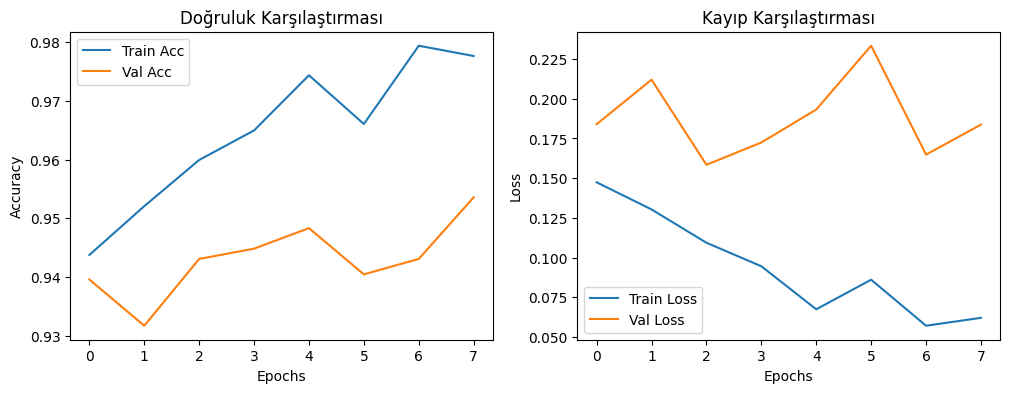

In [21]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_opt.history["accuracy"], label="Train Acc")
plt.plot(history_opt.history["val_accuracy"], label="Val Acc")
plt.title("Doğruluk Karşılaştırması")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_opt.history["loss"], label="Train Loss")
plt.plot(history_opt.history["val_loss"], label="Val Loss")
plt.title("Kayıp Karşılaştırması")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


*Sonuç:**  
Model, yüksek doğruluk ve düşük kayıp değerleriyle iyi performans göstermekte; overfitting kabul edilebilir düzeydedir.

In [22]:
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9322 - loss: 0.1832
Test Accuracy: 0.9405, Test Loss: 0.1759


### 15 .Test Görüntüleri Üzerinde Tahminlerin Görselleştirilmesi

Bu kod, modelin test veri seti üzerindeki tahminlerini görselleştirir.

- Test veri setinden bir batch alınır.
- Model, bu batch içindeki görüntüler için tahmin yapar.
- İlk 9 görüntü 3x3 grid içinde gösterilir.
- Her görüntünün başlığında **gerçek sınıf** ve **modelin tahmini** yazılır.
- Görseller normalizasyonu geri çevrilip 0-255 aralığında gösterilir.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


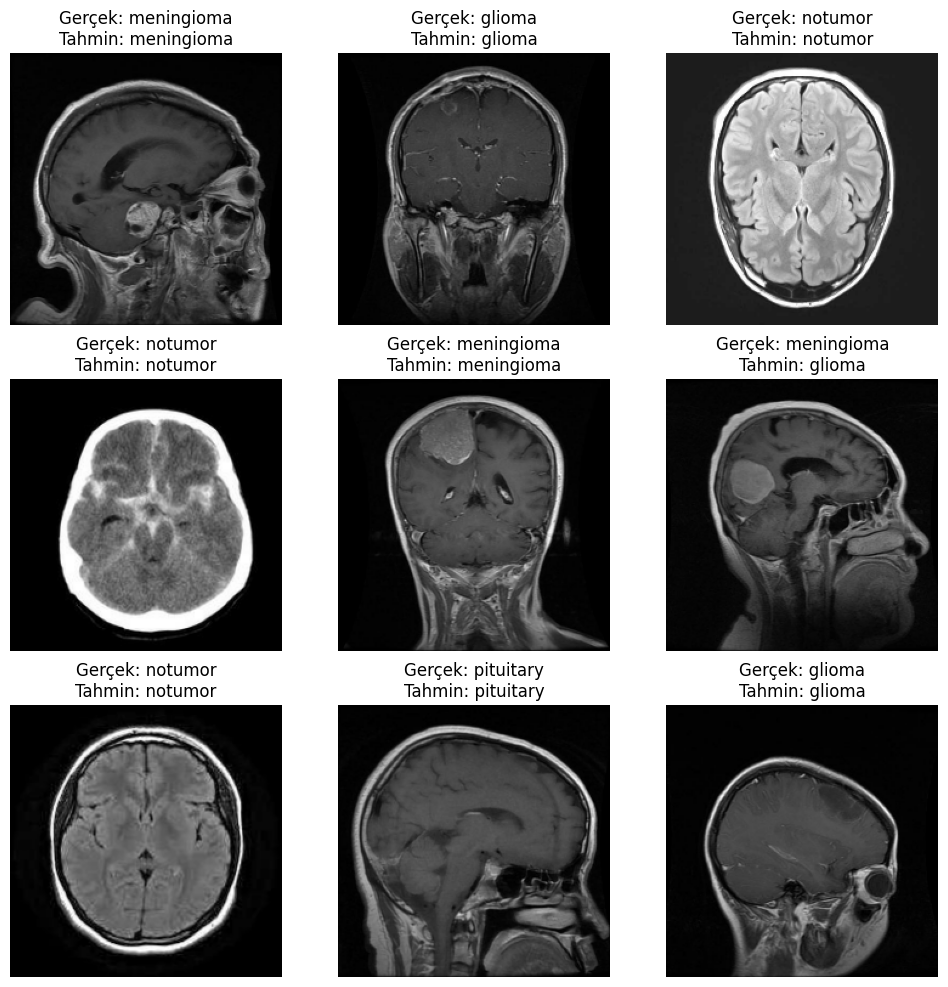

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
    preds = best_model.predict(images)
    for i in range(9):
        plt.subplot(3,3,i+1)
        # Normalize edilmiş görüntüyü 0-255 aralığına çevir
        img = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(img)
        plt.title(f"Gerçek: {class_names[labels[i]]}\nTahmin: {class_names[np.argmax(preds[i])]}")
        plt.axis("off")
plt.show()


Sonuç:Modelin tahminlerini görsel olarak incelenebilmektedir.

### 16. Grad-CAM ile Modelin Karar Mekanizmasını Görselleştirme

- Bu kod, CNN modelinin **hangi bölgeleri inceleyerek tahmin yaptığını** görselleştirmek için Grad-CAM tekniğini kullanır.
- Modelin karar verdiği özellikleri bir **ısı haritası (heatmap)** olarak görüntüye bindirir.
- Böylece modelin beyin tümörü tespiti yaparken hangi alanlara dikkat ettiğini anlayabiliriz.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


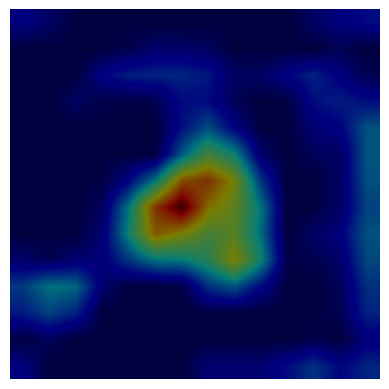

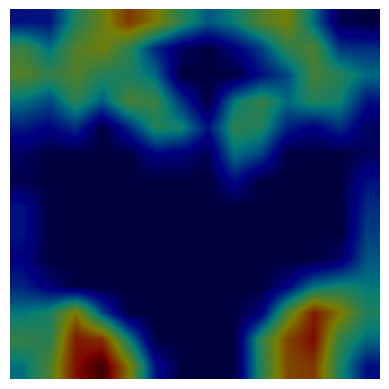

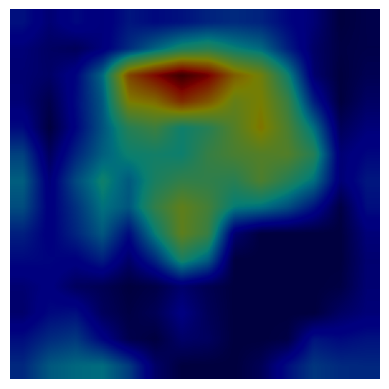

In [26]:
import cv2
def show_gradcam(img, model, class_idx=None):
    img_array = np.expand_dims(img, axis=0)
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name="block5_conv3", pred_index=class_idx)
    plt.imshow(img.astype("uint8"))
    plt.imshow(cv2.resize(heatmap, (img.shape[1], img.shape[0])), cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()

# Örnek 3 test görseli
for images, labels in test_ds.take(1):
    for i in range(3):
        show_gradcam(images[i].numpy(), best_model, class_idx=None)
